# EEG Eye State Dataset - Point Cloud Representation using Takens' Embedding

This notebook demonstrates how to:
1. Load the EEG Eye State dataset
2. Apply Takens' embedding to convert time series to point clouds
3. Visualize the point cloud representations
4. Analyze the topological structure

## What is Takens' Embedding?

Takens' embedding theorem allows us to reconstruct the attractor of a dynamical system from a single time series observation. For a time series `x(t)`, we create points in a higher-dimensional space:

**For 3D embedding:**
- Point at time t: `[x(t), x(t+τ), x(t+2τ)]`
- Where `τ` (tau) is the time delay parameter
- `d` is the embedding dimension

This reveals the underlying structure and dynamics of the EEG signals.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# For Takens' embedding (optional)
try:
    from gtda.time_series import SingleTakensEmbedding
    from gtda.plotting import plot_point_cloud
    GTDA_AVAILABLE = True
    print("✓ giotto-tda available")
except ImportError:
    print("⚠ giotto-tda not available. Install with: pip install giotto-tda")
    GTDA_AVAILABLE = False

# For data fetching
try:
    from ucimlrepo import fetch_ucirepo
    UCI_AVAILABLE = True
    print("✓ ucimlrepo available")
except ImportError:
    print("⚠ ucimlrepo not available. Install with: pip install ucimlrepo")
    UCI_AVAILABLE = False

print("\nLibraries imported successfully!")


✓ giotto-tda available
✓ ucimlrepo available

Libraries imported successfully!


## Step 1: Load EEG Eye State Dataset


In [ ]:
# Load the EEG Eye State dataset
print("=" * 70)
print("STEP 1: Loading EEG Eye State Dataset")
print("=" * 70)

if not UCI_AVAILABLE:
    # Try to load from local file if available
    try:
        data = pd.read_csv('data/eeg_eye_state_full.csv')
        X = data.drop('target', axis=1)
        y = data['target']
        print(f"✓ Loaded from local file: {X.shape[0]} samples, {X.shape[1]} features")
    except FileNotFoundError:
        raise ImportError("Please install ucimlrepo: pip install ucimlrepo")
else:
    # Fetch from UCI repository
    print("Fetching dataset from UCI repository...")
    eeg_eye_state = fetch_ucirepo(id=264)
    X = eeg_eye_state.data.features
    y = eeg_eye_state.data.targets
    print(f"✓ Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

print(f"\nDataset Info:")
print(f"  - Number of samples: {X.shape[0]}")
print(f"  - Number of features (EEG channels): {X.shape[1]}")
print(f"  - Target distribution:")
print(f"    {y.value_counts().to_dict()}")
print(f"    0 = Eye closed, 1 = Eye open")

# Convert to numpy if needed
if isinstance(X, pd.DataFrame):
    X = X.values
if isinstance(y, pd.DataFrame):
    y = y.values.flatten()


STEP 1: Loading EEG Eye State Dataset
Fetching dataset from UCI repository...
✓ Dataset loaded: 14980 samples, 14 features

Dataset Info:
  - Number of samples: 14980
  - Number of features (EEG channels): 14
  - Target distribution:
    {(0,): 8257, (1,): 6723}
    0 = Eye closed, 1 = Eye open


## Step 2: Preprocess the Data


In [ ]:
# Normalize the data
print("=" * 70)
print("STEP 2: Preprocessing Data")
print("=" * 70)

scaler = StandardScaler()
X_processed = scaler.fit_transform(X)
y_processed = y.copy()

print(f"✓ Data normalized using StandardScaler")
print(f"  - Data shape: {X_processed.shape}")
print(f"  - Data range: [{X_processed.min():.2f}, {X_processed.max():.2f}]")
print(f"  - Mean: {X_processed.mean():.4f}, Std: {X_processed.std():.4f}")


STEP 2: Preprocessing Data
✓ Data normalized using StandardScaler
  - Data shape: (14980, 14)
  - Data range: [-72.57, 122.39]
  - Mean: -0.0000, Std: 1.0000


## Step 3: Implement Takens' Embedding Function


In [ ]:
def apply_takens_embedding(time_series, dimension=3, time_delay=1, stride=1):
    """
    Apply Takens' embedding to convert a 1D time series into a point cloud.
    
    For a time series x(t), the embedding creates points:
    [x(t), x(t+τ), x(t+2τ), ..., x(t+(d-1)τ)]
    where:
    - d = embedding dimension
    - τ = time delay
    
    Args:
        time_series: 1D array of time series values
        dimension: Embedding dimension (default: 3)
        time_delay: Time delay parameter τ (default: 1)
        stride: Stride for sampling (default: 1)
    
    Returns:
        point_cloud: Array of shape (n_points, dimension)
    """
    n = len(time_series)
    max_index = n - (dimension - 1) * time_delay
    
    if max_index <= 0:
        raise ValueError(f"Time series too short for dimension {dimension} and delay {time_delay}")
    
    # Create point cloud using Takens' embedding
    point_cloud = []
    for i in range(0, max_index, stride):
        point = [time_series[i + j * time_delay] for j in range(dimension)]
        point_cloud.append(point)
    
    return np.array(point_cloud)

print("✓ Takens' embedding function defined")


✓ Takens' embedding function defined


## Step 4: Apply Takens' Embedding to a Single Channel

Let's start with one EEG channel to see how it works.


In [ ]:
# Select a single channel and separate by eye state
print("=" * 70)
print("STEP 4: Applying Takens' Embedding to Single Channel")
print("=" * 70)

channel_idx = 0  # First EEG channel
dimension = 3    # Embedding dimension
time_delay = 1   # Time delay parameter

# Separate data by eye state
closed_indices = np.where(y_processed == 0)[0]
open_indices = np.where(y_processed == 1)[0]

print(f"  - Channel: {channel_idx + 1}")
print(f"  - Embedding dimension (d): {dimension}")
print(f"  - Time delay (τ): {time_delay}")
print(f"  - Closed eye samples: {len(closed_indices)}")
print(f"  - Open eye samples: {len(open_indices)}")

# Create time series for closed and open eyes
closed_series = X_processed[closed_indices, channel_idx]
open_series = X_processed[open_indices, channel_idx]

# Apply Takens' embedding
point_cloud_closed = apply_takens_embedding(closed_series, dimension, time_delay, stride=1)
point_cloud_open = apply_takens_embedding(open_series, dimension, time_delay, stride=1)

print(f"\n✓ Point clouds created:")
print(f"  - Closed eyes: {point_cloud_closed.shape}")
print(f"  - Open eyes: {point_cloud_open.shape}")


STEP 4: Applying Takens' Embedding to Single Channel
  - Channel: 1
  - Embedding dimension (d): 3
  - Time delay (τ): 1
  - Closed eye samples: 8257
  - Open eye samples: 6723

✓ Point clouds created:
  - Closed eyes: (8255, 3)
  - Open eyes: (6721, 3)


Configure Test Framework
[object Object]

## Step 5: Visualize Point Clouds in 3D


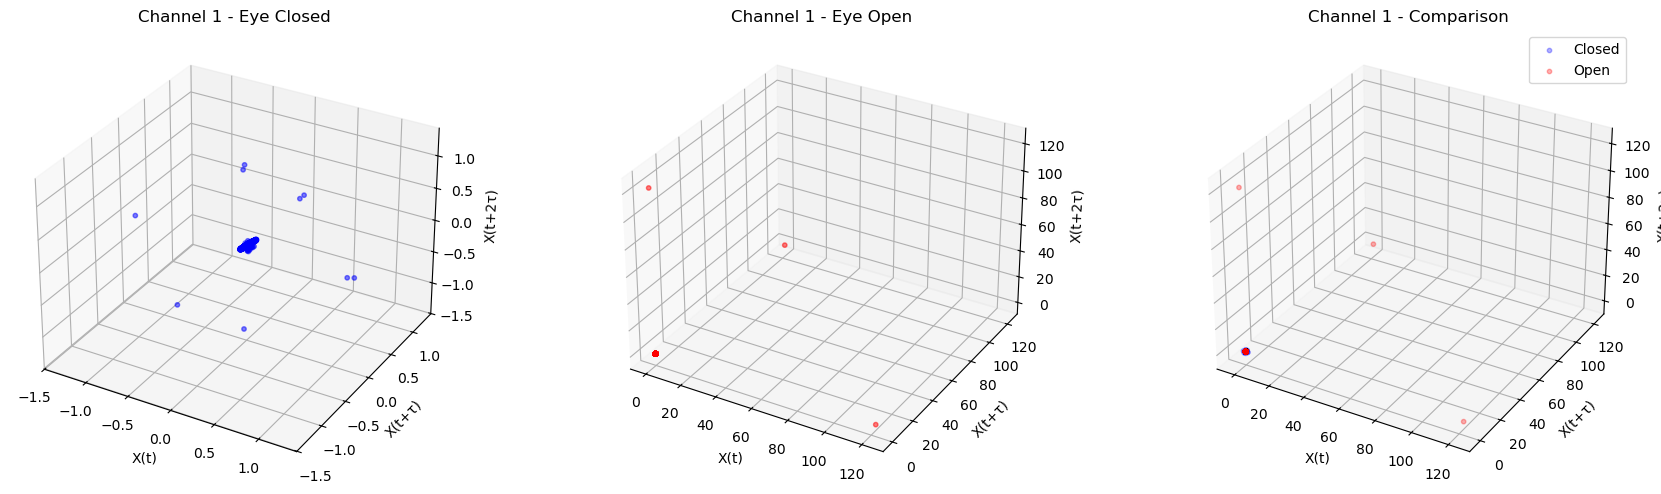

✓ 3D point cloud visualization created


In [ ]:
# Visualize point clouds side by side
fig = plt.figure(figsize=(18, 5))

# Closed eyes
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(point_cloud_closed[:, 0], point_cloud_closed[:, 1], point_cloud_closed[:, 2],
           c='blue', alpha=0.5, s=10)
ax1.set_xlabel('X(t)')
ax1.set_ylabel('X(t+τ)')
ax1.set_zlabel('X(t+2τ)')
ax1.set_title(f'Channel {channel_idx + 1} - Eye Closed')

# Open eyes
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(point_cloud_open[:, 0], point_cloud_open[:, 1], point_cloud_open[:, 2],
           c='red', alpha=0.5, s=10)
ax2.set_xlabel('X(t)')
ax2.set_ylabel('X(t+τ)')
ax2.set_zlabel('X(t+2τ)')
ax2.set_title(f'Channel {channel_idx + 1} - Eye Open')

# Combined comparison
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(point_cloud_closed[:, 0], point_cloud_closed[:, 1], point_cloud_closed[:, 2],
           c='blue', alpha=0.3, s=10, label='Closed')
ax3.scatter(point_cloud_open[:, 0], point_cloud_open[:, 1], point_cloud_open[:, 2],
           c='red', alpha=0.3, s=10, label='Open')
ax3.set_xlabel('X(t)')
ax3.set_ylabel('X(t+τ)')
ax3.set_zlabel('X(t+2τ)')
ax3.set_title(f'Channel {channel_idx + 1} - Comparison')
ax3.legend()

plt.tight_layout()
plt.show()

print("✓ 3D point cloud visualization created")


## Step 6: Create Point Clouds for Multiple Channels


In [ ]:
# Create point clouds for multiple channels
print("=" * 70)
print("STEP 6: Creating Point Clouds for Multiple Channels")
print("=" * 70)

# Sample data for efficiency (optional - remove to use all data)
max_samples_per_class = 500
if len(closed_indices) > max_samples_per_class:
    closed_indices_sampled = np.random.choice(closed_indices, max_samples_per_class, replace=False)
else:
    closed_indices_sampled = closed_indices

if len(open_indices) > max_samples_per_class:
    open_indices_sampled = np.random.choice(open_indices, max_samples_per_class, replace=False)
else:
    open_indices_sampled = open_indices

# Create point clouds for first 3 channels
n_channels_to_process = min(3, X_processed.shape[1])
point_clouds_closed = []
point_clouds_open = []

for ch_idx in range(n_channels_to_process):
    closed_series = X_processed[closed_indices_sampled, ch_idx]
    open_series = X_processed[open_indices_sampled, ch_idx]
    
    pc_closed = apply_takens_embedding(closed_series, dimension, time_delay, stride=1)
    pc_open = apply_takens_embedding(open_series, dimension, time_delay, stride=1)
    
    point_clouds_closed.append(pc_closed)
    point_clouds_open.append(pc_open)
    
    print(f"  ✓ Channel {ch_idx + 1}: Closed={pc_closed.shape}, Open={pc_open.shape}")

print(f"\n✓ Created point clouds for {n_channels_to_process} channels")


STEP 6: Creating Point Clouds for Multiple Channels
  ✓ Channel 1: Closed=(498, 3), Open=(498, 3)
  ✓ Channel 2: Closed=(498, 3), Open=(498, 3)
  ✓ Channel 3: Closed=(498, 3), Open=(498, 3)

✓ Created point clouds for 3 channels


## Step 7: Visualize Multiple Channels


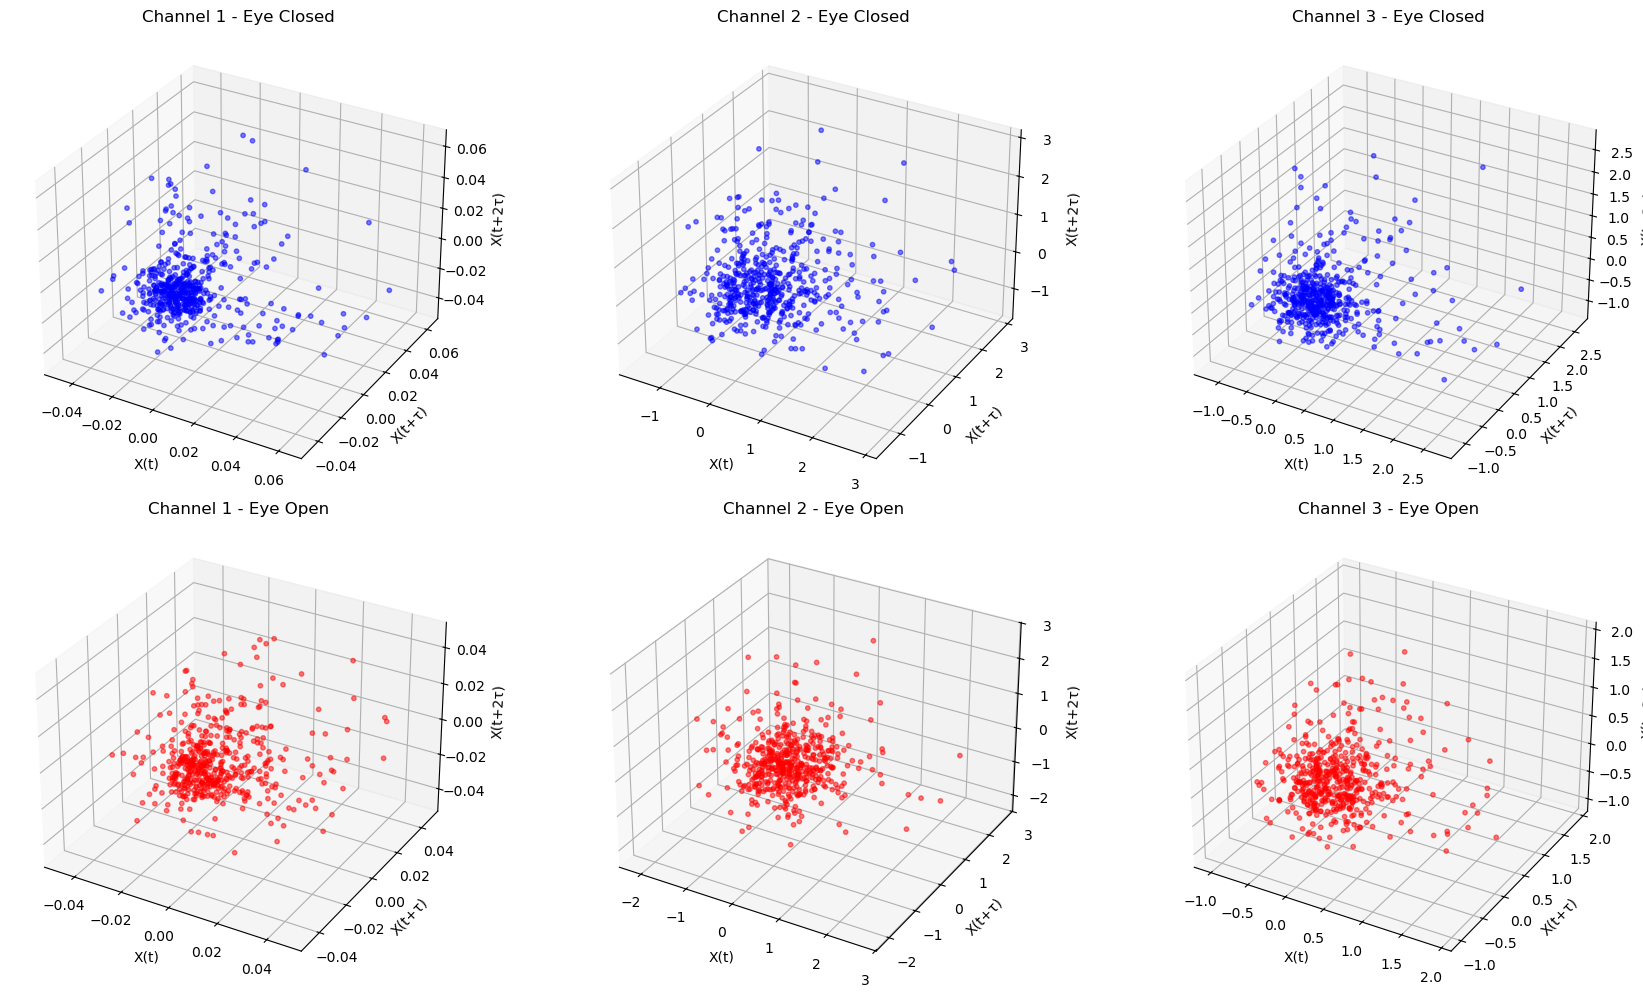

✓ Multi-channel visualization created


In [ ]:
# Visualize multiple channels
fig = plt.figure(figsize=(6 * n_channels_to_process, 10))

for i in range(n_channels_to_process):
    # Closed eyes
    ax1 = fig.add_subplot(2, n_channels_to_process, i + 1, projection='3d')
    pc_closed = point_clouds_closed[i]
    ax1.scatter(pc_closed[:, 0], pc_closed[:, 1], pc_closed[:, 2],
               c='blue', alpha=0.5, s=10)
    ax1.set_title(f'Channel {i+1} - Eye Closed')
    ax1.set_xlabel('X(t)')
    ax1.set_ylabel('X(t+τ)')
    ax1.set_zlabel('X(t+2τ)')
    
    # Open eyes
    ax2 = fig.add_subplot(2, n_channels_to_process, i + n_channels_to_process + 1, projection='3d')
    pc_open = point_clouds_open[i]
    ax2.scatter(pc_open[:, 0], pc_open[:, 1], pc_open[:, 2],
               c='red', alpha=0.5, s=10)
    ax2.set_title(f'Channel {i+1} - Eye Open')
    ax2.set_xlabel('X(t)')
    ax2.set_ylabel('X(t+τ)')
    ax2.set_zlabel('X(t+2τ)')

plt.tight_layout()
plt.show()

print("✓ Multi-channel visualization created")


## Step 8: Analyze Point Cloud Properties


In [ ]:
# Analyze point cloud statistics
print("=" * 70)
print("STEP 8: Analyzing Point Cloud Properties")
print("=" * 70)

print("\nPoint Cloud Statistics:")
print("-" * 80)
print(f"{'Channel':<15} {'State':<10} {'N Points':<12} {'Mean':<12} {'Std':<12} {'Range':<12}")
print("-" * 80)

for i, (pc_closed, pc_open) in enumerate(zip(point_clouds_closed, point_clouds_open)):
    # Closed eyes
    print(f"{f'Channel {i+1}':<15} {'Closed':<10} {len(pc_closed):<12} "
          f"{pc_closed.mean():<12.4f} {pc_closed.std():<12.4f} "
          f"{pc_closed.max()-pc_closed.min():<12.4f}")
    
    # Open eyes
    print(f"{f'Channel {i+1}':<15} {'Open':<10} {len(pc_open):<12} "
          f"{pc_open.mean():<12.4f} {pc_open.std():<12.4f} "
          f"{pc_open.max()-pc_open.min():<12.4f}")
    print("-" * 80)

# Compute pairwise distances (sample for efficiency)
print("\nDistance Statistics (sampled):")
sample_size = min(100, len(point_clouds_closed[0]))
sample_indices = np.random.choice(len(point_clouds_closed[0]), sample_size, replace=False)

pc_closed_sample = point_clouds_closed[0][sample_indices]
pc_open_sample = point_clouds_open[0][sample_indices]

dist_closed = pdist(pc_closed_sample)
dist_open = pdist(pc_open_sample)

print(f"  - Mean pairwise distance (closed): {dist_closed.mean():.4f}")
print(f"  - Mean pairwise distance (open): {dist_open.mean():.4f}")
print(f"  - Std pairwise distance (closed): {dist_closed.std():.4f}")
print(f"  - Std pairwise distance (open): {dist_open.std():.4f}")


STEP 8: Analyzing Point Cloud Properties

Point Cloud Statistics:
--------------------------------------------------------------------------------
Channel         State      N Points     Mean         Std          Range       
--------------------------------------------------------------------------------
Channel 1       Closed     498          -0.0091      0.0163       0.1089      
Channel 1       Open       498          -0.0071      0.0143       0.0932      
--------------------------------------------------------------------------------
Channel 2       Closed     498          0.0712       0.7025       4.3870      
Channel 2       Open       498          -0.1386      0.6202       4.8002      
--------------------------------------------------------------------------------
Channel 3       Closed     498          -0.0126      0.5300       3.8207      
Channel 3       Open       498          -0.0110      0.4370       2.9205      
---------------------------------------------------------

## Step 9: PCA Projection for Visualization

For higher-dimensional embeddings, we can use PCA to project to 2D for easier visualization.


STEP 9: PCA Projection Visualization


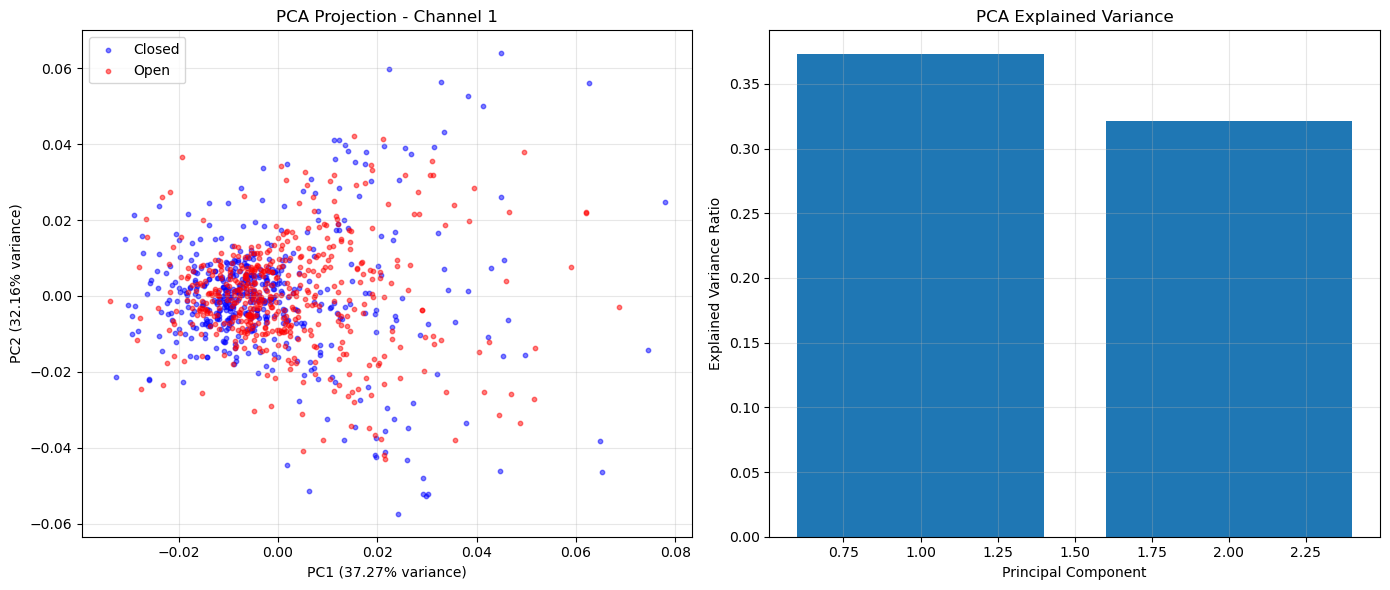

✓ PCA visualization created
  - PC1 explains 37.27% of variance
  - PC2 explains 32.16% of variance


In [ ]:
# Apply PCA for 2D visualization
print("=" * 70)
print("STEP 9: PCA Projection Visualization")
print("=" * 70)

channel_idx = 0
pc_closed = point_clouds_closed[channel_idx]
pc_open = point_clouds_open[channel_idx]

# Combine and apply PCA
combined = np.vstack([pc_closed, pc_open])
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split back
n_closed = len(pc_closed)
closed_pca = combined_pca[:n_closed]
open_pca = combined_pca[n_closed:]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 2D projection
axes[0].scatter(closed_pca[:, 0], closed_pca[:, 1], c='blue', alpha=0.5, s=10, label='Closed')
axes[0].scatter(open_pca[:, 0], open_pca[:, 1], c='red', alpha=0.5, s=10, label='Open')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'PCA Projection - Channel {channel_idx + 1}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Explained variance
axes[1].bar(range(1, min(10, len(pca.explained_variance_ratio_)) + 1),
           pca.explained_variance_ratio_[:10])
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('PCA Explained Variance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ PCA visualization created")
print(f"  - PC1 explains {pca.explained_variance_ratio_[0]:.2%} of variance")
print(f"  - PC2 explains {pca.explained_variance_ratio_[1]:.2%} of variance")


## Step 10: Experiment with Different Parameters

Try different embedding dimensions and time delays to see how they affect the point cloud structure.


STEP 10: Experimenting with Different Parameters


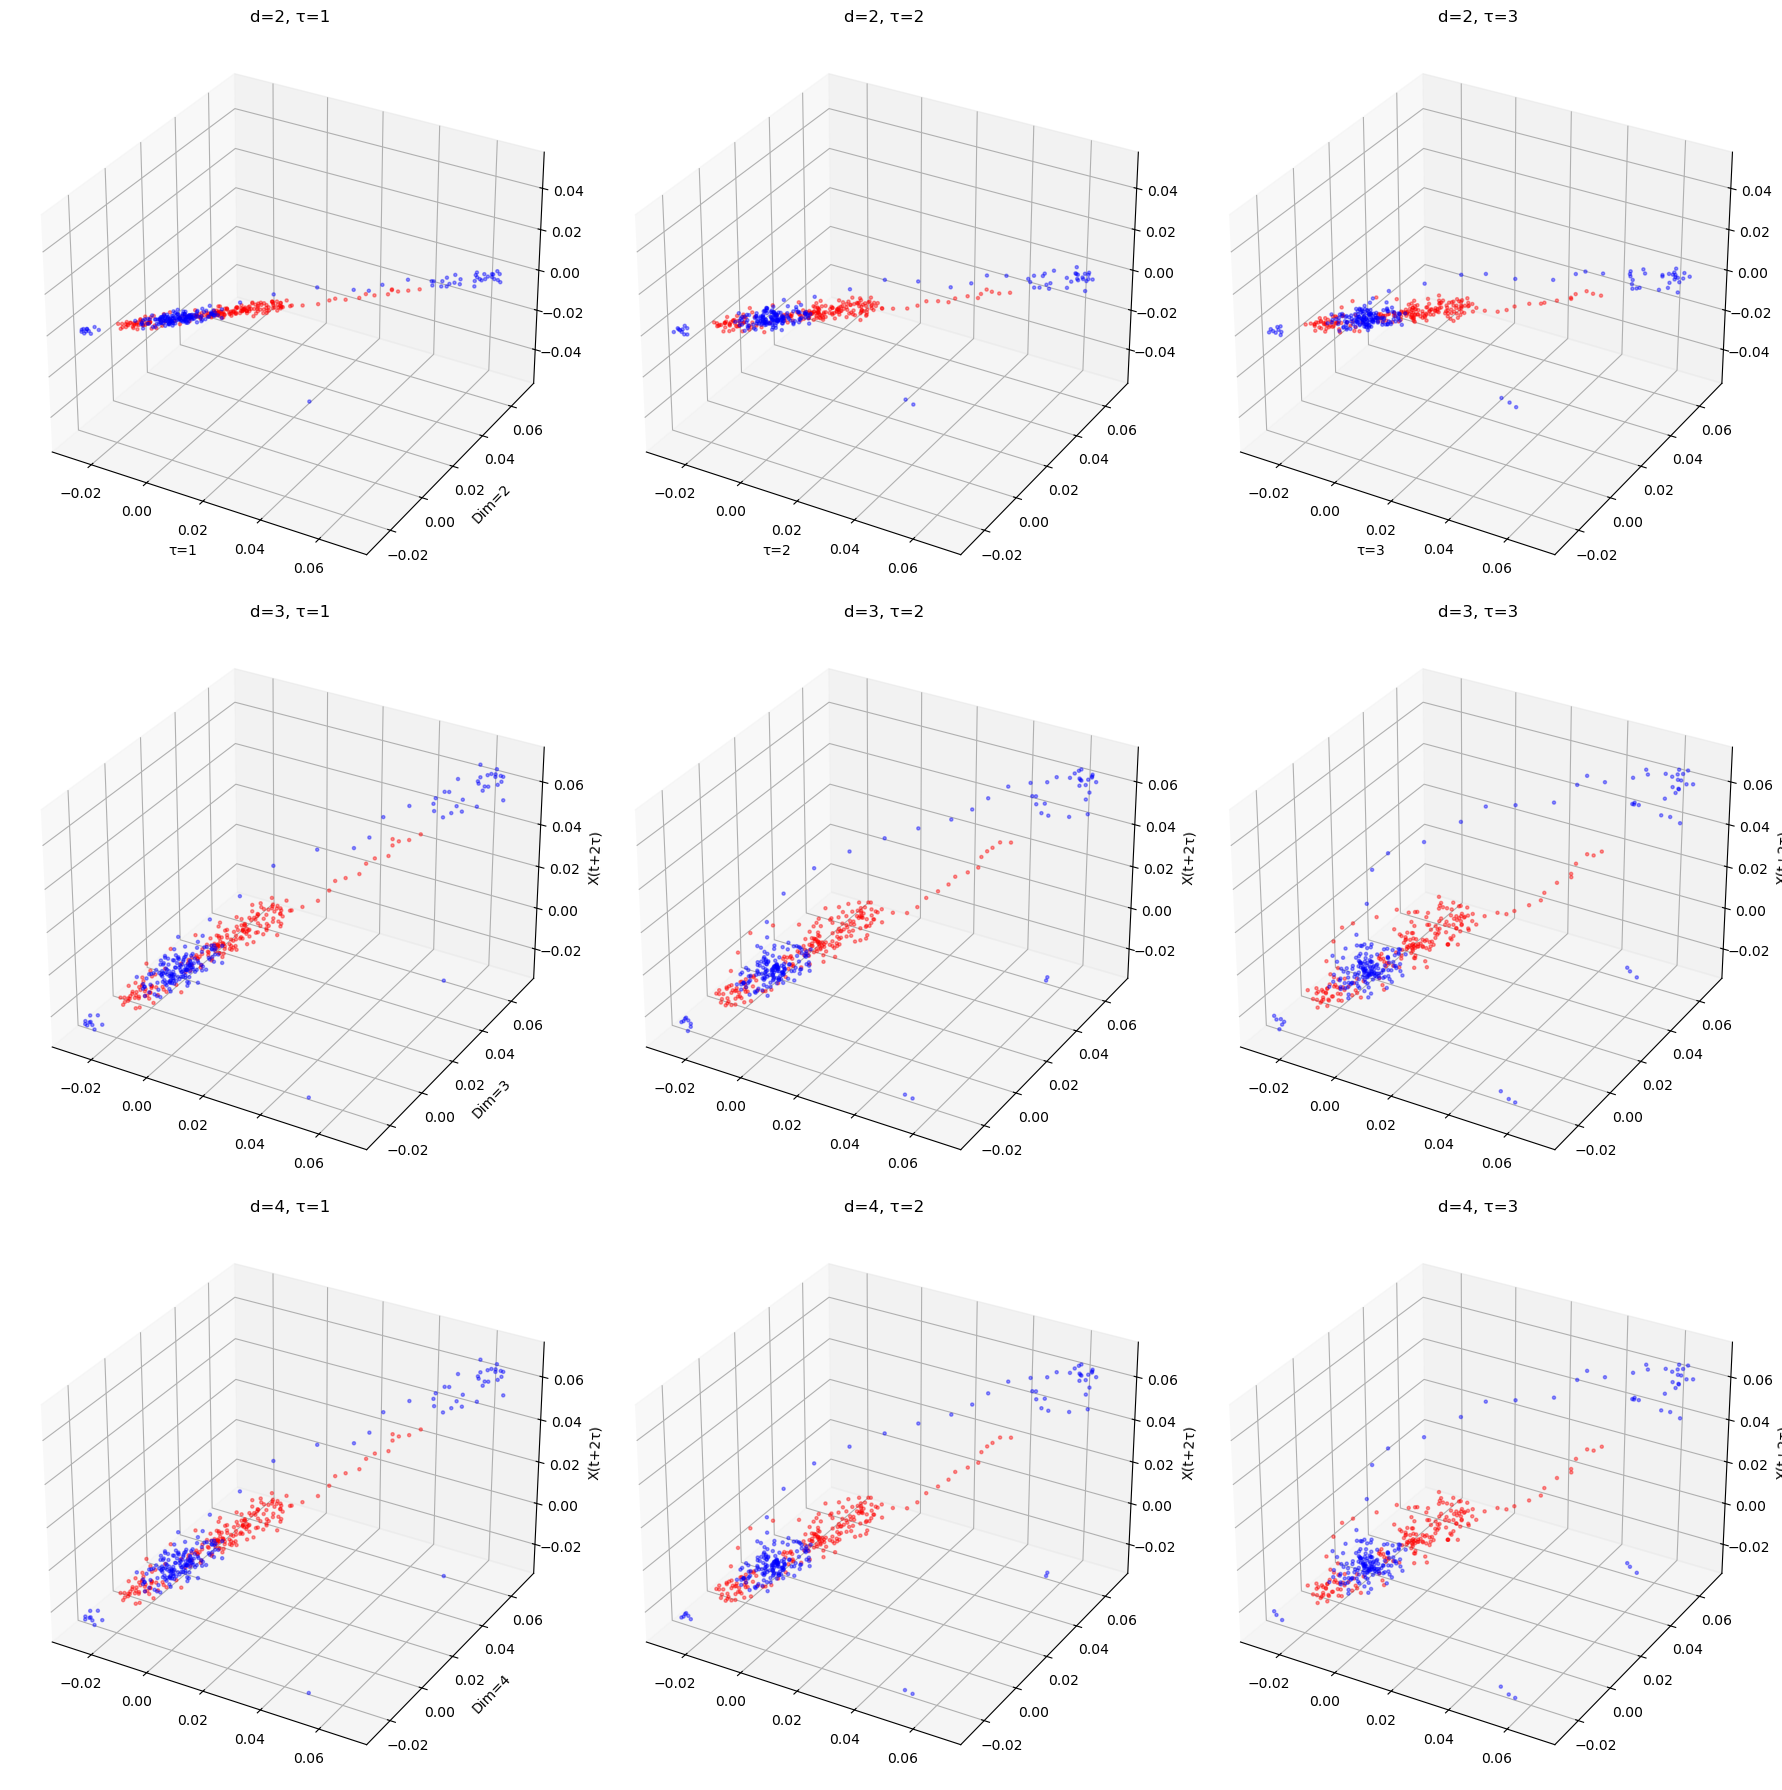

✓ Parameter comparison visualization created


In [ ]:
# Experiment with different parameters
print("=" * 70)
print("STEP 10: Experimenting with Different Parameters")
print("=" * 70)

# Test different dimensions
dimensions = [2, 3, 4]
time_delays = [1, 2, 3]

# Use a smaller sample for faster computation
sample_size = 200
closed_sample = X_processed[closed_indices[:sample_size], channel_idx]
open_sample = X_processed[open_indices[:sample_size], channel_idx]

fig, axes = plt.subplots(len(dimensions), len(time_delays), 
                        figsize=(6*len(time_delays), 6*len(dimensions)),
                        subplot_kw={'projection': '3d'})

for i, dim in enumerate(dimensions):
    for j, tau in enumerate(time_delays):
        try:
            pc_closed = apply_takens_embedding(closed_sample, dim, tau, stride=1)
            pc_open = apply_takens_embedding(open_sample, dim, tau, stride=1)
            
            ax = axes[i, j]
            ax.scatter(pc_closed[:, 0], pc_closed[:, 1], pc_closed[:, 2] if dim >= 3 else np.zeros(len(pc_closed)),
                      c='blue', alpha=0.4, s=5, label='Closed')
            ax.scatter(pc_open[:, 0], pc_open[:, 1], pc_open[:, 2] if dim >= 3 else np.zeros(len(pc_open)),
                      c='red', alpha=0.4, s=5, label='Open')
            ax.set_title(f'd={dim}, τ={tau}')
            if dim >= 3:
                ax.set_zlabel('X(t+2τ)')
        except:
            axes[i, j].text(0.5, 0.5, 'Error', ha='center', va='center')
            axes[i, j].set_title(f'd={dim}, τ={tau}')

# Set labels for first row and column
for i in range(len(dimensions)):
    axes[i, 0].set_ylabel(f'Dim={dimensions[i]}')
for j in range(len(time_delays)):
    axes[0, j].set_xlabel(f'τ={time_delays[j]}')

plt.tight_layout()
plt.show()

print("✓ Parameter comparison visualization created")


In [1]:
from scipy.spatial.distance import pdist

# Parameters (adjust as needed)
channel_idx = 0
time_delay = 2
max_dim_limit = 12            # max dimension to try
sample_size = 500             # sample per class for speed
plateau_threshold = 0.05      # relative change threshold (5%)
plateau_consecutive = 2       # require this many consecutive small changes

# Prepare series (use available samples)
closed_series = X_processed[closed_indices[:sample_size], channel_idx]
open_series   = X_processed[open_indices[:sample_size], channel_idx]

def max_allowed_dim(series, tau):
    n = len(series)
    return max(1, int(np.floor((n - 1) / tau) + 1))

max_dim = min(max_dim_limit, max_allowed_dim(closed_series, time_delay), max_allowed_dim(open_series, time_delay))

dims = list(range(1, max_dim + 1))
mean_dist_closed = []
mean_dist_open = []
valid_dims = []

for d in dims:
    try:
        pc_c = apply_takens_embedding(closed_series, d, time_delay, stride=1)
        pc_o = apply_takens_embedding(open_series,   d, time_delay, stride=1)
        if len(pc_c) < 2 or len(pc_o) < 2:
            # not enough points to compute distances
            continue
        mdc = pdist(pc_c).mean()
        mdo = pdist(pc_o).mean()
        mean_dist_closed.append(mdc)
        mean_dist_open.append(mdo)
        valid_dims.append(d)
    except Exception:
        # skip invalid dimensions
        continue

valid_dims = np.array(valid_dims)
mean_dist_closed = np.array(mean_dist_closed)
mean_dist_open = np.array(mean_dist_open)

# Detect plateau for closed (can also use open or combined)
rel_changes = np.abs(np.diff(mean_dist_closed) / (mean_dist_closed[:-1] + 1e-12))
candidate_dim = None
if len(rel_changes) >= plateau_consecutive:
    for i in range(len(rel_changes) - (plateau_consecutive - 1)):
        window = rel_changes[i:i + plateau_consecutive]
        if np.all(window < plateau_threshold):
            candidate_dim = int(valid_dims[i + 1])  # plateau detected at the latter dimension in the window
            break

# Plot
plt.figure(figsize=(8, 5))
plt.plot(valid_dims, mean_dist_closed, marker='o', label='Closed (mean pairwise dist)')
plt.plot(valid_dims, mean_dist_open,   marker='s', label='Open   (mean pairwise dist)')
if candidate_dim is not None:
    plt.axvline(candidate_dim, color='gray', linestyle='--', alpha=0.7)
    plt.text(candidate_dim + 0.2, max(mean_dist_closed.max(), mean_dist_open.max())*0.95,
             f'candidate d≈{candidate_dim}', rotation=90, va='top', color='gray')
plt.xlabel('Embedding dimension (d)')
plt.ylabel('Mean pairwise distance')
plt.title(f'Mean pairwise distance vs embedding dimension (channel {channel_idx+1}, τ={time_delay})')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Candidate dimensionality (closed series):", candidate_dim)
# ...existing code...

NameError: name 'X_processed' is not defined

## Summary

This notebook demonstrated:

1. **Loading EEG Eye State Dataset** - 14 channels of EEG signals with eye state labels
2. **Preprocessing** - Normalization for consistent scaling
3. **Takens' Embedding** - Converting 1D time series to 3D point clouds
4. **Visualization** - 3D scatter plots showing the attractor structure
5. **Multi-channel Analysis** - Processing multiple EEG channels
6. **Statistical Analysis** - Comparing properties of point clouds
7. **PCA Projection** - 2D visualization for easier interpretation
8. **Parameter Exploration** - Testing different embedding dimensions and time delays

### Key Insights:

- **Point clouds reveal the underlying dynamics** of EEG signals
- **Different eye states** (closed vs open) show **distinct patterns** in the point cloud structure
- **Embedding parameters** (dimension and time delay) affect the shape of the point cloud
- This representation is useful for **topological data analysis** and **pattern recognition**

### Next Steps:

- Apply persistent homology to analyze topological features
- Use point cloud distances for classification
- Explore higher-dimensional embeddings
- Apply to other time series datasets
